# Transformed Temporal Similarity Search

Transformed Temporal Similarity Search is our patent-pending compression model designed to dimensionally reduce time series windows by more than 99%. With Transformed Temporal Similarity Search, KDB.AI can compress times series windows containing thousands of data points, into significantly smaller dimensions, all while maintaining the integrity of the original data’s shape. These compressed windows are then stored within KDB.AI as vector embeddings, setting up the ability to execute vector searches and enabling the efficient analysis of time series datasets.

This notebook uses sample market data, creates an index using the Transformed Temporal Similiarity Search feature exposed by KDB.AI, and searches for a pattern of interest in the data.

Agenda:
1. Imports & Setup
2. Define KDB.AI Session
3. Generate Synthetic Market Time Series Data
4. Method 1: Only Windowing
5. Method 2: Transformed TSS
6. Search Evaluation 
7. Drop the Table

## 1. Imports & Setup

In [ ]:
!pip install kdbai_client

In [ ]:
### !!! Only run this cell if running the notebook in Colab
### This downloads sample market data into Colab
!mkdir ./data 
!wget -P ./data https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/TSS_transformed/data/marketTrades.parquet

In [ ]:
# KX Dependencies
import kdbai_client as kdbai
# Other Dependencies
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from getpass import getpass
import time

In [24]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Dependencies for metric gathering
import psutil
import datetime

# Report memory usage of Python + KDB.AI
def get_memory_usage():
    virtual_memory = psutil.virtual_memory()
    return virtual_memory.used / (1024 ** 2)  # Memory usage in megabytes

## 2. Define KDB.AI Session
KDB.AI comes in two offerings:

KDB.AI Cloud - For experimenting with smaller generative AI projects with a vector database in our cloud.
KDB.AI Server - For evaluating large scale generative AI applications on-premises or on your own cloud provider.
Depending on which you use there will be different setup steps and connection details required.

Option 1. KDB.AI Cloud
To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free here.

You can connect to a KDB.AI Cloud session using kdbai.Session and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables KDBAI_ENDPOINTS and KDBAI_API_KEY exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect. If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

### Option 1. KDB.AI Cloud

In [ ]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [ ]:
### Start Session with KDB.AI Cloud
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Option 2. KDB.AI Server
To use KDB.AI Server, you will need download and run your own container. To do this, you will first need to sign up for free [here](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html).

You will receive an email with the required license file and bearer token needed to download your instance. Follow instructions in the signup email to get your session up and running.

Once the setup steps are complete you can then connect to your KDB.AI Server session using kdbai.Session and passing your local endpoint.

In [26]:
session = kdbai.Session()

## 3. Load Synthetic Market Time Series Data
We have pre-generated 50,000 data points for example stocks 'AAA' and 'BBB' in a parquet file called `marketTrades.parquet`. Let's load these to a dataframe where:

- time: When the trade took place
- sym: The symbol of the stock being traded
- qty: The quantity of stock traded
- price: The price of the stock being traded

In [27]:
df = pd.read_parquet('data/marketTrades.parquet')

## Method 1: Only Windowing
This method is shown as a point of comparison for the Transformed TSS method

### Vector Construction

In [28]:
# Create the vector column
D = 1000 # Sliding Window Size
vecdf = df.groupby(['sym']).apply(
    lambda x: pd.DataFrame({
        'sym': x['sym'].iloc[0],
        'time': sliding_window_view(x['time'], D)[:, 0],  # Adjusted to keep the last time in the window
        'price': list(sliding_window_view(x['price'], D))
    })
).reset_index(drop=True).reset_index()
memory_vecdf_created=get_memory_usage()

In [29]:
vecdf.head()

,index,sym,time,price
0,0,AAA,2024-02-17 00:01:04.748290926,"[25.258074262645096, 25.328340356005356, 24.88..."
1,1,AAA,2024-02-17 00:01:11.262136101,"[25.328340356005356, 24.882380010094494, 25.18..."
2,2,AAA,2024-02-17 00:02:02.104950249,"[24.882380010094494, 25.189861855935305, 25.44..."
3,3,AAA,2024-02-17 00:02:08.149878233,"[25.189861855935305, 25.443228425458074, 25.25..."
4,4,AAA,2024-02-17 00:02:35.474111437,"[25.443228425458074, 25.251197177916765, 25.45..."


### Index Construction

In [30]:
# If we're re-running this, remove the old trade table
if 'trade' in session.list():
    table = session.table('trade')
    table.drop()

In [31]:
# Define the schema with similar columns to the dataframe. The price column is where the time series vectors will be inserted 
# We are doing similarity search on the raw time series vectors created above
schema = dict(
    columns=[
        dict(
            name='index', 
            pytype='int64'
            ),
        dict(
            name='sym', 
            pytype='str'
            ),
        dict(
            name='time', 
            pytype='datetime64[ns]'
            ),
        dict(
            name='price', 
            pytype='float32',
            vectorIndex=
                dict(
                    type='flat', 
                    metric='L2',
                    dims=1000
                    )
            )
        ]
    )

In [32]:
table = session.create_table('trade', schema)

### Index Population
Insert the data into KDB.AI

In [33]:
n = 1000  # number of rows per batch

for i in tqdm(range(0, vecdf.shape[0], n)):
    table.insert(vecdf[i:i+n].reset_index(drop=True))

memory_raw_windows_in_table=get_memory_usage()

100%|███████████████████████████████████████████████████████████████████████████| 99/99 [02:00<00:00,  1.21s/it]


### Search

We take the hundredth vector and use that as our search vector

In [34]:
q = vecdf['price'][100].tolist()

Text(0.5, 1.0, 'Query Vector')

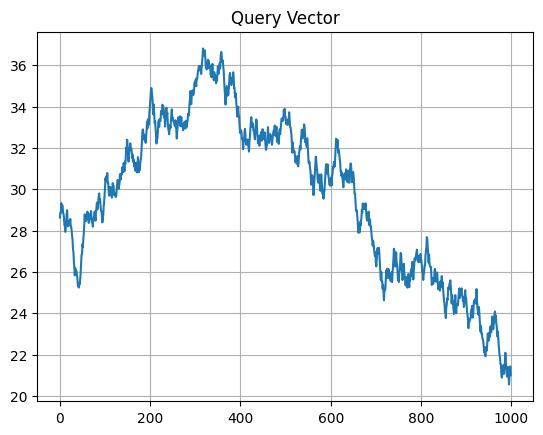

In [35]:
plt.plot(q) # See what the search vector looks like
plt.grid(True)
plt.title('Query Vector')

In [36]:
raw_start=datetime.datetime.now()
res = table.search(vectors=[q], n=10)[0]
raw_stop=datetime.datetime.now()
memory_raw_windows_post_search=get_memory_usage()
res

,index,sym,time,price,__nn_distance
0,100,AAA,2024-02-17 00:44:10.438550859,"[28.628259375691414, 28.854478302178904, 28.84...",0.000000
1,99,AAA,2024-02-17 00:44:02.638653516,"[28.81325367023237, 28.628259375691414, 28.854...",82.707275
2,101,AAA,2024-02-17 00:45:13.110510259,"[28.854478302178904, 28.846883268328384, 29.33...",82.741821
3,98,AAA,2024-02-17 00:43:31.947510391,"[28.602465968346223, 28.81325367023237, 28.628...",168.146683
4,102,AAA,2024-02-17 00:45:19.669315963,"[28.846883268328384, 29.33366368082352, 29.034...",168.171356
5,97,AAA,2024-02-17 00:42:45.272446721,"[28.55717873433605, 28.602465968346223, 28.813...",251.906540
6,103,AAA,2024-02-17 00:45:21.212457865,"[29.33366368082352, 29.034837207291275, 29.214...",252.123642
7,104,AAA,2024-02-17 00:45:23.664466291,"[29.034837207291275, 29.214529692661017, 29.19...",331.735596
8,96,AAA,2024-02-17 00:42:19.691716432,"[28.135981646133587, 28.55717873433605, 28.602...",332.039398
9,105,AAA,2024-02-17 00:45:25.577250123,"[29.214529692661017, 29.19519697735086, 28.861...",411.366882


As expected, our 100th vector, which is identical to the query vector 'q', was returned as the top result. We also see that the vectors surrounding the 100th vector are also returned, which is expected as they will also contain large segments similar to the query vector.

## Method 2: Transformed Temporal Similarity Search
Now, we will create a table to enable the embedding and compression of the original raw time series windows. This will reduce the size of the windows from 1000 data points to only 8. (>99% reduction), while maintaining the integrity of the original data's shape.

The original windows can have various numbers of data points within them as long as they all have a similar time frame, for example each representing one minute of time. This makes searching over data that has different sample rates straightforward. 

Ensure that the windows being searched for, and the windows being searched over are for the same time frame. This means that if the windows compressed and stored using Transformed Temporal Similarity Search are 1 minute windows, the query vector must also have a time frame of 1 minute. 


### Index Construction

In [37]:
# If we're re-running this, remove the old trade table
if 'trade' in session.list():
    table = session.table('trade')
    table.drop()

In [38]:
# Define the schema with similar columns to the dataframe. The price column is where the time series vectors will be inserted 
# The price column will now have an embedding where 'tsc' is defined 
# 'tsc' represents Transformed Temporal Similarity Search
# Now inserted 1000 dimension data will be compressed with 'tsc' to 8 dimensions and stored in KDB.AI
schema = dict(
    columns=[
        dict(
            name='index', 
            pytype='int64'
            ),
        dict(
            name='sym', 
            pytype='str'
            ),
        dict(
            name='time', 
            pytype='datetime64[ns]'
            ),
        dict(
            name='price', 
            pytype='float32',
            vectorIndex=
                dict(
                    type='flat', 
                    metric='L2',
                    dims=1000
                    ),
            embedding=
                dict(
                    dims=8, 
                    type='tsc', 
                    on_insert_error='reject_all',
                    )
            )
        ]
    )

In [39]:
table = session.create_table('trade', schema)
memory_tsc_pre_populate=get_memory_usage()

### Index Population
Insert the data into KDB.AI

In [40]:
n = 1000  # number of rows per batch

for i in tqdm(range(0, vecdf.shape[0], n)):
    table.insert(vecdf[i:i+n].reset_index(drop=True))
    
memory_tsc_post_populate=get_memory_usage()

100%|███████████████████████████████████████████████████████████████████████████| 99/99 [01:49<00:00,  1.11s/it]


### Search

Run similarity search using our query vector q (the 100th vector in our dataset), and returning the top 10 most similar matches.


In [41]:
tsc_start=datetime.datetime.now()
res = table.search(vectors=[q], n=10)[0]
tsc_stop=datetime.datetime.now()
memory_tsc_windows_post_search=get_memory_usage()
res.merge(vecdf, on=['index','sym','time'], how='left')

,index,sym,time,__nn_distance,price
0,100,AAA,2024-02-17 00:44:10.438550859,0.000000,"[28.628259375691414, 28.854478302178904, 28.84..."
1,100,AAA,2024-02-17 00:44:10.438550859,0.000000,"[28.628259375691414, 28.854478302178904, 28.84..."
2,101,AAA,2024-02-17 00:45:13.110510259,0.000228,"[28.854478302178904, 28.846883268328384, 29.33..."
3,101,AAA,2024-02-17 00:45:13.110510259,0.000228,"[28.854478302178904, 28.846883268328384, 29.33..."
4,99,AAA,2024-02-17 00:44:02.638653516,0.000228,"[28.81325367023237, 28.628259375691414, 28.854..."
5,99,AAA,2024-02-17 00:44:02.638653516,0.000228,"[28.81325367023237, 28.628259375691414, 28.854..."
6,98,AAA,2024-02-17 00:43:31.947510391,0.000909,"[28.602465968346223, 28.81325367023237, 28.628..."
7,98,AAA,2024-02-17 00:43:31.947510391,0.000909,"[28.602465968346223, 28.81325367023237, 28.628..."
8,102,AAA,2024-02-17 00:45:19.669315963,0.000916,"[28.846883268328384, 29.33366368082352, 29.034..."
9,102,AAA,2024-02-17 00:45:19.669315963,0.000916,"[28.846883268328384, 29.33366368082352, 29.034..."


**N.B.** We observe the returned indexes lay either side of the index of our query vector. This passes our sanity check as the vectors offset by a few indexes is simply the query pattern shifted slightly left and right. If we want to have more meaningful results we can either increase the number of nearest neighbors returned, or in our sliding window creation we can have windows that aren't largely overlapping. 

We can clearly see the high correlation between the query vector and the non-trivial nearest neighbors

## 6. Search Evaluation

We see that our memory usage increases drastically when we insert raw vectors into KDB.AI. Under the TSC method there is less memory required and faster response times. The improvement of this correlates to the level of dimensionality reduction that's taking place, or $\frac{D}{dims}$$$

### Memory Usage 

In [42]:
raw_used=memory_raw_windows_post_search-memory_vecdf_created
tsc_used=memory_tsc_windows_post_search-memory_tsc_pre_populate
print(f"Raw  (MB): {raw_used:.2f}")
print(f"TSC  (MB):  {tsc_used:.2f}")
print(f"DIFF (MB): {raw_used-tsc_used:.2f}")

Raw  (MB): 1204.43
TSC  (MB):  106.38
DIFF (MB): 1098.04


### Search Timings

In [43]:
### Function to calculate how long a similarity search takes
def datetime_difference(datetime1, datetime2):
    # Calculate the difference between the two datetime objects
    difference = datetime2 - datetime1

    # Calculate total seconds and milliseconds from the difference
    total_seconds = difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    milliseconds = int((total_seconds - int(total_seconds)) * 1000)

    # Print the difference in hours, minutes, seconds, and milliseconds
    return f"Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Milliseconds: {milliseconds}"

In [44]:
print('Raw: ' + datetime_difference(raw_start, raw_stop))
print('Transformed TSS: ' + datetime_difference(tsc_start,tsc_stop))

Raw: Hours: 0, Minutes: 0, Seconds: 0, Milliseconds: 152
Transformed TSS: Hours: 0, Minutes: 0, Seconds: 0, Milliseconds: 14


### 7. Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()